# CVR 预估基线版本

### 2.1 基于广告统计的版本

只是基于广告本身做了一个统计。也就是说忽略了用户 和 上下文的信息，只关注广告本身。

In [ ]:
import zipfile
import numpy as np
import pandas as pd

#load data
data_root = '.'
dfTrain = pd.read_csv("%s/train.csv" % data_root)
dfTest = pd.read_csv("%s/test.csv" % data_root)
dfAd = pd.read_csv("%s/ad.csv" % data_root)

#process data
dfTrain = pd.merge(dfTrain, dfAd, on='creativeID')
dfTest = pd.merge(dfTest, dfAd, on='creativeID')
y_train = dfTrain['label'].values

#model building

#针对每个appID ,求出对应的转化率
key = "appID"
#因为label的值不是0就是1，那么 np.mean(df['label'])) 求均值 也就是等于求label为1的概率，也就是转化率
dfCvr = dfTrain.groupby(key).apply(lambda df: np.mean(df['label'])).reset_index()
dfCvr.colums = [key, 'avg_cvr']
dfTest = pd.merge(dfTest, dfCvr, how="left", on=key)
dfTest['avg_cvr'].fillna(np.mean(dfTrain['label']), inplace=True)
proba_test = dfTest["avg_cvr"].values

#submission
df = pd.DataFrame({"instanceID":dfTest['instanceID'].values, "proba": proba_test})
df.sort_values("instanceID", inplace=True)
df.to_csv("submission.csv",index = False)

with zipfile.ZipFile("submission.zip", "W") as fout:
    fout.write("submission.csv", compress_type=ZIP_DEFLATED)


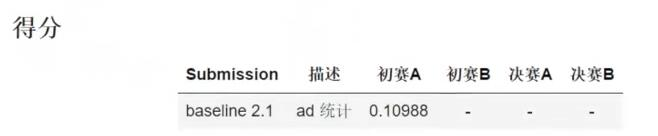

### 2.2 AD+LR 版本

In [ ]:
import zipfile
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression


#load data
data_root = '.'
dfTrain = pd.read_csv("%s/train.csv" % data_root)
dfTest = pd.read_csv("%s/test.csv" % data_root)
dfAd = pd.read_csv("%s/ad.csv" % data_root)

#process data
dfTrain = pd.merge(dfTrain, dfAd, on='creativeID')
dfTest = pd.merge(dfTest, dfAd, on='creativeID')
y_train = dfTrain['label'].values

#feature enginnering/encoding
enc = OneHotEncoder()
feats = ["creativeID", "adID", "camgaignID", "advertiserID", "appID", "appPlatform"]
for i,feat in enumerate(feats):
    x_train = enc.fit_transform(dfTrain[feat].values.reshape(-1, 1))
    x_test = enc.fit_transform(dfTest[feat].values.reshape(-1, 1))
    if i == 0:
        X_trian, X_test = x_train, x_test
    else
        #sparse 表示使用一个稀疏向量，是为了避免内存不够，因为维度很高
        X_trian, X_test = sparse.hstack((X_trian, x_train)), sparse.hstack((X_test, x_test))
        

#model training
lr = LogisticRegression()
lr.fit(X_trian, y_train)
proba_test = lr.predict_proba(X_test)[:, 1]


#submission
df = pd.DataFrame({"instanceID":dfTest['instanceID'].values, "proba": proba_test})
df.sort_values("instanceID", inplace=True)
df.to_csv("submission.csv",index = False)

with zipfile.ZipFile("submission.zip", "W") as fout:
    fout.write("submission.csv", compress_type=ZIP_DEFLATED)


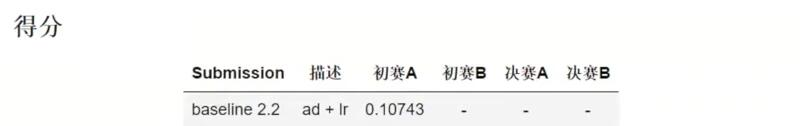